# BLAST Model for Comparing Autoimmune Features

In [164]:
import re, os
import requests
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import networkx as nx

from mst_clustering import MSTClustering

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from scipy.sparse.csgraph import minimum_spanning_tree

def get_gene(record):
    try:
        return re.search('GN=(.*?) ', record.description).group(1)
    except AttributeError:
        return ''

In [218]:
df = pd.read_csv('../evalue_matrix.csv').iloc[:, 1:]
def v(x):
    if x == 0:
        return 0 
    elif x == 1:
        return 1
    elif x < 1e-5:
        return 1
    else:
        0


df = df.applymap(v)

In [219]:
Tcsr = minimum_spanning_tree(df)
X = Tcsr.toarray()

In [228]:
G = nx.from_numpy_matrix(Tcsr.toarray())

In [229]:
layout = nx.spring_layout(G, k=0.25, iterations=10)

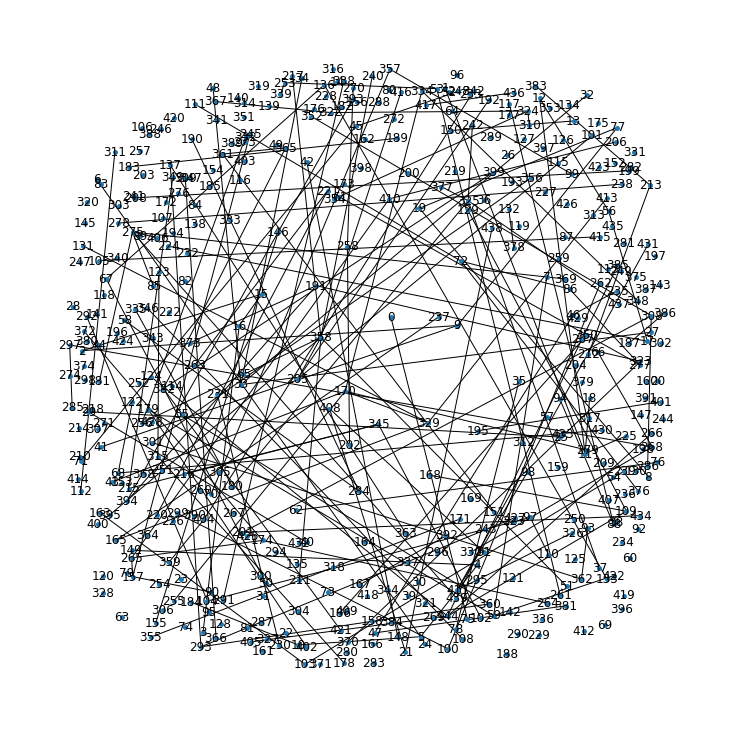

In [230]:
plt.figure(figsize=(10,10))
nx.draw(G, layout, with_labels=True, node_size=15)

In [232]:
G

In [223]:
model = MSTClustering(cutoff_scale=1)
labels = model.fit_predict(Tcsr.toarray())

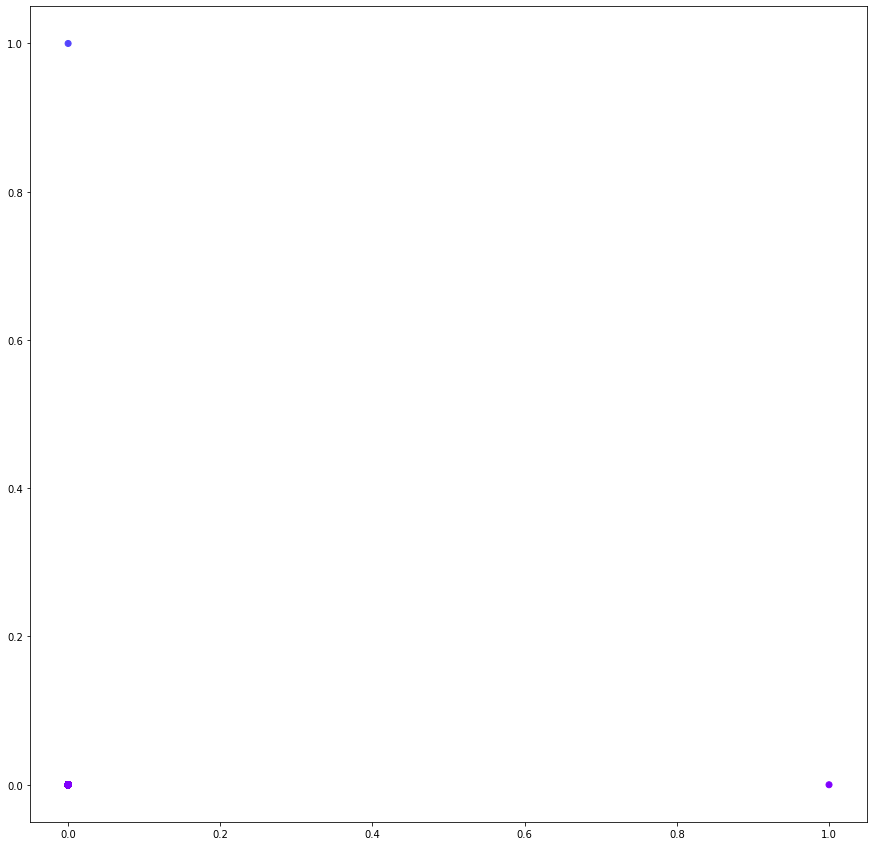

In [235]:
plt.figure(figsize=(15,15))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow');

In [5]:
ai = list(SeqIO.parse('autoimmune_antigens.fasta', 'fasta'))

ids   = [record.id.split('|')[1] for record in ai]
genes = [get_gene(record) for record in ai]
seqs  = [str(record.seq) for record in ai]
df    = pd.DataFrame({'id': ids, 'gene': genes, 'seq': seqs})

# df.to_csv('autoimmune_antigens.csv')

In [7]:
cancer = list(SeqIO.parse('cancer_antigens.fasta', 'fasta'))

ids  = [record.id.split('|')[1] for record in cancer]
genes = [get_gene(record) for record in cancer]
seqs = [str(record.seq) for record in cancer]
df    = pd.DataFrame({'id': ids, 'gene': genes, 'seq': seqs})

# df.to_csv('cancer_antigens.csv')

In [11]:
human = list(SeqIO.parse('../data/human_proteome.fasta', 'fasta'))

ids  = [record.id.split('|')[1] for record in human]
genes = [get_gene(record) for record in human]
seqs = [str(record.seq) for record in human]
names = [re.search(' (.*) OS', record.description).group(1) for record in human] 
df    = pd.DataFrame({'id': ids, 'name': names, 'gene': genes, 'seq': seqs})

# df.to_csv('human_proteome.csv')

In [15]:
id_to_name_map = {}
for record in human:
    id_to_name_map[record.id.split('|')[1]] = re.search(' (.*) OS', record.description).group(1)

In [9]:
df = pd.read_csv('human_proteome.csv', index_col=0)
df = df.dropna(subset=['gene'])

In [10]:
df['autoimmune'] = df['gene'].isin(pd.read_csv('autoimmune_antigens.csv', index_col=0)['gene'])

In [45]:
df.to_csv('human_proteome.csv')

In [46]:
df

,id,name,gene,seq,autoimmune
0,A0A087WT01,T cell receptor alpha variable 27,TRAV27,MVLKFSVSILWIQLAWVSTQLLEQSPQFLSIQEGENLTVYCNSSSV...,False
2,A0AUZ9,KAT8 regulatory NSL complex subunit 1-like pro...,KANSL1L,MTPALREATAKGISFSSLPSTMESDKMLYMESPRTVDEKLKGDTFS...,False
3,A1A580,Keratin-associated protein 23-1,KRTAP23-1,MSYNCCCGNFSSHSCEGYLCYSGYSRGGSSYPSNLVYSTEPLISQH...,False
4,A6NIH7,Protein unc-119 homolog B,UNC119B,MSGSNPKAAAAASAAGPGGLVAGKEEKKKAGGGVLNRLKARRQAPH...,False
5,A6NM03,Olfactory receptor 2AG2,OR2AG2,MELRNSTLGSGFILVGILNDSGSPELLYATFTILYMLALTSNGLLL...,False
...,...,...,...,...,...
20595,Q9Y250,Leucine zipper putative tumor suppressor 1,LZTS1,MGSVSSLISGHSFHSKHCRASQYKLRKSSHLKKLNRYSDGLLRFGF...,False
20596,Q9Y3M8,StAR-related lipid transfer protein 13,STARD13,MFSQVPRTPASGCYYLNSMTPEGQEMYLRFDQTTRRSPYRMSRILA...,False
20597,Q9Y458,T-box transcription factor TBX22,TBX22,MALSSRARAFSVEALVGRPSKRKLQDPIQAEQPELREKKGGEEEEE...,False
20598,Q9Y663,Heparan sulfate glucosamine 3-O-sulfotransfera...,HS3ST3A1,MAPPGPASALSTSAEPLSRSIFRKFLLMLCSLLTSLYVFYCLAERC...,False


In [47]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [49]:


count = 1
sequences = []
for i, row in train.iterrows():
    id = row['id'] + '-autoimmune-train-%s' % str(count) if row['autoimmune'] else row['id'] + '-normal-train-%s' % str(count)
    record = SeqRecord(
        Seq(row['seq']),
        id = id,
        description = row['name']
)
    sequences.append(record)
    count+=1

    
with open("train.fasta", "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")
    

count = 1
sequences = []
for i, row in test.iterrows():
    id = row['id'] + '-autoimmune-test-%s' % str(count) if row['autoimmune'] else row['id'] + '-normal-test-%s' % str(count)
    record = SeqRecord(
        Seq(row['seq']),
        id = id,
        description = row['name']
)
    sequences.append(record)
    count+=1
    
    
with open("test.fasta", "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")

In [50]:
from Bio.Blast.Applications import NcbiblastpCommandline
import os

In [51]:
os.system('/home/dan/projects/apps/ncbi-blast-2.10.0+/bin/makeblastdb -in train.fasta -dbtype prot')



Building a new DB, current time: 09/16/2022 10:21:52
New DB name:   /home/dan/projects/antigen_classification/train.fasta
New DB title:  train.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/dan/projects/antigen_classification/train.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 16305 sequences in 0.352901 seconds.




0

In [52]:
test = SeqIO.parse('/home/dan/projects/antigen_classification/test.fasta', 'fasta')

In [53]:
blastx_cline = NcbiblastpCommandline(cmd     = '/home/dan/projects/apps/ncbi-blast-2.10.0+/bin/blastp',
                                      query  = '/home/dan/projects/antigen_classification/test.fasta',
                                      db     = '/home/dan/projects/antigen_classification/train.fasta',
                                      evalue = 100, outfmt = 10, out='output.csv')
stdout, stderr = blastx_cline()

In [12]:
df = pd.read_csv('../blast/output.csv', names = ['Test', 'Train', 'Sequence Identity', 
                                                'Length', 'Mismatches', 'Gap Openings', 'Query start', 
                                                'Query end', 'Index start', 'Index end', 'e value', 'bit score'])

idx = df.groupby(['Test'])['Sequence Identity'].transform(max) == df['Sequence Identity']
r = df[idx].drop_duplicates(['Test'])
r['test_normal'] = ~r['Test'].str.contains('autoimmune')
r['train_normal'] = ~r['Test'].str.contains('autoimmune')
r['Test UniProt ID'] = r['Test'].str.split('-').str[0]
r['Test Name'] = r['Test UniProt ID'].map(id_to_name_map)
r['Train UniProt ID'] = r['Train'].str.split('-').str[0]
r['Train Name'] = r['Train UniProt ID'].map(id_to_name_map)
r['correct'] = r['Test'].str.split('-').str[1] == r['Train'].str.split('-').str[1]

ai_test = r[~r['test_normal']]
normal_test = r[r['test_normal']]

In [16]:
r.to_csv('../data/seq_id.csv')

In [14]:
r = pd.read_csv('BLAST_results.csv')

In [22]:
X = r['Sequence Identity']
y = ~r['test_normal']

fpr, tpr, thresh = roc_curve(y, X)
roc_df = pd.DataFrame(zip(fpr, tpr, thresh), columns = ['FPR', 'TPR', 'Threshold'])

fig = px.area(roc_df, x='FPR', y='TPR', hover_data = ['Threshold'], title='BLAST Model - Autoimmune Prediction')
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.add_annotation(x=0.5, y=0.4, text=f'AUC={roc_auc_score(y, X):.2f}', showarrow=False)
fig.update_layout(width=600, height=600)

fig.show()

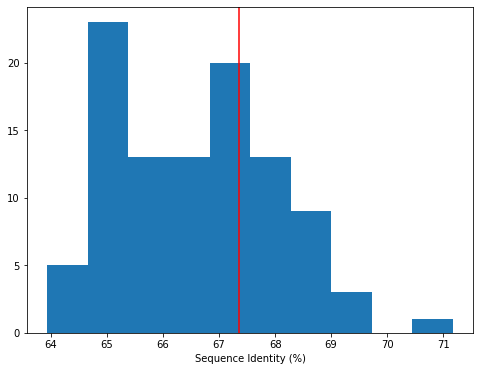

In [13]:
means = []
for i in range(100):
    means.append(normal_test.sample(n=60)['Sequence Identity'].mean())

plt.figure(figsize=(8,6))
plt.hist(means, bins=10)
plt.xlabel('Sequence Identity (%)')
plt.axvline(ai_test['Sequence Identity'].mean(),color = 'red')

In [154]:
df = pd.read_csv('BLAST_results.csv')

In [157]:
df[~df['normal']].to_csv('autoimmune_BLAST_results.csv')

In [164]:
id_to_gene_map = dict(zip(human_proteome['id'], human_proteome['gene']))

In [160]:
df = pd.read_csv('autoimmune_BLAST_results.csv')

In [166]:
df['Test Gene'] = df['Test UniProt ID'].map(id_to_gene_map)
df['Train Gene'] = df['Train UniProt ID'].map(id_to_gene_map)

In [168]:
df.to_csv('autoimmune_BLAST_results.csv')

In [186]:
df = pd.read_csv('test_autoimmune_BLAST_results.csv')

In [187]:
df['correct'] = df['Test'].str.split('-').str[1] == df['Train'].str.split('-').str[1]

In [189]:
df.to_csv('test_autoimmune_BLAST_results.csv')